# Dog Breed Classification

A Machine Learning model to classify 133 dog breeds, using dog breed dataset provided by Udacity (https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)

VGG11 pretrained model from pytorch vision is used in this project.
Reference: https://pytorch.org/vision/master/generated/torchvision.models.vgg11.html

Using this pretrained model, breeds of dogs were classified.


In [2]:
# installing packages
!pip install smdebug
!pip install torch --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils 

In [3]:
# importing packages
import sagemaker
import boto3
import os
from sagemaker.pytorch import PyTorch
import torch

## Dataset

Dataset used for this project is Dog breed dataset provided by Udacity. This dataset contains 133 dog breeds. The goal is to train a model to classify different dog breeds

In [4]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"

In [ ]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2021-12-12 23:14:46--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  37.9MB/s    in 34s     

2021-12-12 23:15:22 (31.5 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [5]:
# # use default S3 bucket
# bucket = sagemaker_session.default_bucket()
# os.environ["DEFAULT_S3_BUCKET"] = bucket

In [10]:
# use default S3 bucket
bucket = sagemaker_session.default_bucket()

import os
# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-956692068952/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg to s3://sagemaker-us-east-1-956692068952/dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-956692068952/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg to s3://sagemaker-us-east-1-956692068952/dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://sagemaker-us-east-1-956692068952/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://sagemaker-us-east-1-956692068952/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/002

## Hyperparameter Tuning
**TODO:** This is the part where we will finetune a pretrained model with hyperparameter tuning. The hyperparameters chosen for this purpose are learning rate and batch size, where learning rate is a continuous parameter and batch size is a categorical parameter

**Note:** We will need to use the `hpo_vgg11.py` script to perform hyperparameter tuning.

In [8]:
# Declare HP ranges
from sagemaker.tuner import (
    #IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256])
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [9]:
# Creating estimators for Hyperparameter tuning jobs

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo_vgg11.py",
    base_job_name = 'hpo_tuning_dog_breed_pretrained_vgg11',
    role=role,
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
    )


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [6]:
# assigning S3 paths for the training job
s3_data = "s3://{}/{}/".format(bucket, "dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= s3_data
os.environ['SM_MODEL_DIR']= s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

In [12]:
# Fit the HP Tuner with input data channel
# In the hpo_vgg11.py the splitting of s3_data to train_loader, test_loader, validation_loader is done.
tuner.fit({'train' : s3_data},wait=True) 

................................................................................................................................................................................................................................................................................................................................................................!


In [13]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

# Getting the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-13 06:57:02 Starting - Preparing the instances for training
2021-12-13 06:57:02 Downloading - Downloading input data
2021-12-13 06:57:02 Training - Training image download completed. Training in progress.
2021-12-13 06:57:02 Uploading - Uploading generated training model
2021-12-13 06:57:02 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'lr': '0.0015372117789691237',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_tuning_dog_breed_pretrained_vgg11-2021-12-13-06-29-31-830"',
 'sagemaker_program': '"hpo_vgg11.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-956692068952/hpo_tuning_dog_breed_pretrained_vgg11-2021-12-13-06-29-31-830/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Note:** We will need to use the `train_model_vgg11.py` script to perform model profiling and debugging.

In [7]:
# Setting up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [8]:
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.pytorch import PyTorch

In [9]:
# Create and fit an estimator with best parameters

hyperparameters = {"batch_size": "32", "lr": "0.0015372117789691237"} # Training with best parameters
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model_vgg11.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

# In the train_model_vgg11.py the splitting of s3_data to train_loader, test_loader, validation_loader is done.
estimator.fit({'train' : s3_data},wait=True)

2021-12-13 17:48:02 Starting - Starting the training job...
2021-12-13 17:48:25 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2021-12-13 17:49:26 Starting - Preparing the instances for training......
2021-12-13 17:50:29 Downloading - Downloading input data............
2021-12-13 17:52:28 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-13 17:52:43,163 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-12-13 17:52:43,183 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-13 17:52:43,798 sagemaker_pytorch_container.training INFO     Invoking user training script.

2021-12-13 17:53:07 Training - Training image download completed. Training in progress.20

In [10]:
# Plot a debugging output.

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))


Training jobname: pytorch-training-2021-12-13-17-48-02-194
Region: us-east-1
[2021-12-13 17:57:49.257 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-13 17:57:49.292 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-956692068952/pytorch-training-2021-12-13-17-48-02-194/debug-output
[2021-12-13 17:57:52.466 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-13 17:57:53.484 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/VGG_classifier.0.bias', 'gradient/VGG_classifier.0.weight', 'gradient/VGG_classifier.3.bias', 'gradient/VGG_classifier.3.weight', 'gradient/VGG_classifier.6.bias', 'gradient/VGG_classifier.6.weight']
21
54


In [11]:
tensor_name = "CrossEntropyLoss_output_0"

In [12]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [13]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200],
 [array(5.0916376, dtype=float32),
  array(5.5619802, dtype=float32),
  array(4.915119, dtype=float32),
  array(5.3329597, dtype=float32),
  array(4.9607477, dtype=float32),
  array(4.988955, dtype=float32),
  array(5.1095095, dtype=float32),
  array(4.865261, dtype=float32),
  array(4.879981, dtype=float32),
  array(5.197138, dtype=float32),
  array(4.8823733, dtype=float32),
  array(4.970457, dtype=float32),
  array(5.027837, dtype=float32),
  array(4.8880105, dtype=float32),
  array(4.92703, dtype=float32),
  array(4.778918, dtype=float32),
  array(4.881653, dtype=float32),
  array(4.7693233, dtype=float32),
  array(4.884355, dtype=float32),
  array(4.7897515, dtype=float32),
  array(4.843074, dtype=float32)])

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


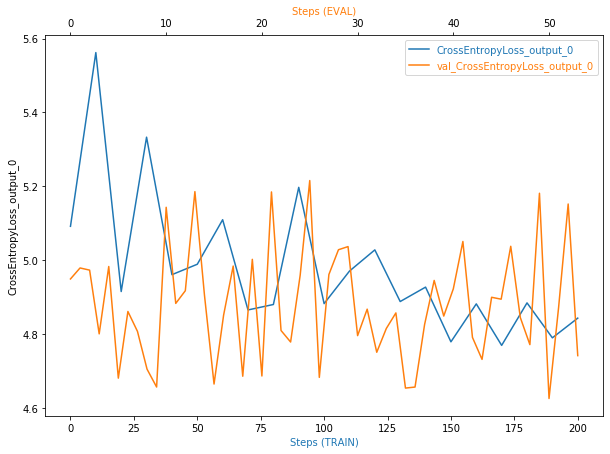

In [15]:
plot_tensor(trial, "CrossEntropyLoss_output_0") #Plotting the loss

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

**From the plot it is evident that smooth line is not obtained. There is so much of variations.**

**To get a smooth line we can try to adjust the pretrained model and fully connected layers**


In [16]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-956692068952/pytorch-training-2021-12-13-17-48-02-194/rule-output


In [17]:
! aws s3 ls {rule_output_path} --recursive

2021-12-13 17:55:41     335928 pytorch-training-2021-12-13-17-48-02-194/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-13 17:55:41     178317 pytorch-training-2021-12-13-17-48-02-194/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-13 17:55:37        191 pytorch-training-2021-12-13-17-48-02-194/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-13 17:55:37       7970 pytorch-training-2021-12-13-17-48-02-194/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-13 17:55:37        126 pytorch-training-2021-12-13-17-48-02-194/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-13 17:55:37        129 pytorch-training-2021-12-13-17-48-02-194/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-13 17:55:37       3703 pytorch-training-2021-12-13-17-48-02-194/rule-output/ProfilerReport/profiler-output/profiler-re

In [18]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-956692068952/pytorch-training-2021-12-13-17-48-02-194/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-956692068952/pytorch-training-2021-12-13-17-48-02-194/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-956692068952/pytorch-training-2021-12-13-17-48-02-194/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-956692068952/pytorch-training-2021-12-13-17-48-02-194/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-956692068952/pytorc

In [19]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [20]:
import IPython
# output the profiler report
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

**While performing predictions from endpoint, got a model error. Hence used an inference script. Reference: https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#load-a-model**

In [21]:
#Manually set the model location for re-running purpose and kerneldied issues
model_location= "s3://sagemaker-us-east-1-956692068952/pytorch-training-2021-12-13-17-48-02-194/output/model.tar.gz"

In [22]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [23]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [24]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='endpoint_vgg11.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor) 

In [25]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

---------!

In [56]:
with open("./testdogImage.jpg", "rb") as f:
    payload = f.read()
    
type(payload)

bytes

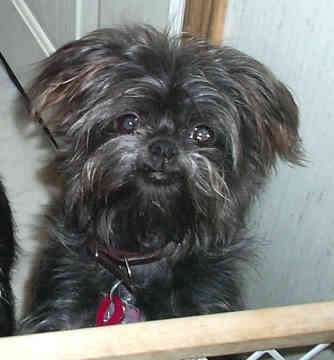

In [57]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [58]:
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response

[[-0.6550412178039551,
  -1.4086523056030273,
  -0.9851670861244202,
  -0.7654270529747009,
  -0.6900366544723511,
  -0.7324790954589844,
  -1.0222206115722656,
  -1.264918327331543,
  -1.1331474781036377,
  -0.8539180755615234,
  -0.6392209529876709,
  -0.6902279853820801,
  -1.0797630548477173,
  -0.08987662941217422,
  -0.7254661917686462,
  -1.2482177019119263,
  -0.4485085606575012,
  -0.8423632383346558,
  -0.9378435611724854,
  -0.8569598197937012,
  -1.0687003135681152,
  -0.9653103947639465,
  -0.9660505056381226,
  -0.535958468914032,
  -0.9708380103111267,
  -1.239914894104004,
  -0.8606815338134766,
  -0.8148423433303833,
  -0.5580692291259766,
  -0.913530170917511,
  -0.9879534244537354,
  -0.7254608869552612,
  -1.0281188488006592,
  -0.7002164721488953,
  -0.6382884979248047,
  -0.5608609318733215,
  -1.1612845659255981,
  -0.6054598093032837,
  -0.35151487588882446,
  -0.9146957993507385,
  -0.6013659834861755,
  -0.7663393020629883,
  -0.7261112928390503,
  -0.42263352

In [59]:
import torch
import numpy as np
np.argmax(response, 1)

array([13])

Predicted as Australian_terrier. Prediction is pretty well.

In [60]:
# delete the endpoint once work is done as it charges overtime
predictor.delete_endpoint()